In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import glob, dill, sys, os
from jaxstar.mistfit import MistFit, MistGridIso
from jax.scipy.ndimage import map_coordinates as mapc

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True*0)

In [5]:
d = pd.read_csv("../../input/isoinput_cks_valid.csv")

In [7]:
d['logplx'] = np.log10(d.parallax)

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
stats = ["mean", "median", "std", "min", "max"]
print (d.agg({"logplx": stats, "parallax_over_error": stats, "kmag_err_corrected": stats, "teff": stats, "feh": stats}))

          logplx  parallax_over_error  kmag_err_corrected         teff  \
mean    0.170474           145.237645            0.026508  5662.124293   
median  0.146219           104.843995            0.023168  5710.350000   
std     0.256337           160.839456            0.012297   436.360181   
min    -0.846577            -4.200069            0.011000  4617.700000   
max     1.437081          2455.805200            0.119221  6631.000000   

             feh  
mean    0.031073  
median  0.042000  
std     0.180148  
min    -0.687000  
max     0.440000  


In [17]:
mass_min, mass_max = 0.7, 1.3
kmag_err = 0.023 # median
parallax_over_err = 100 # median
logplx_mean, logplx_std = 0.17, 0.26
feh_mean, feh_std = 0.03, 0.18
eep_max = 600

In [18]:
teff_err, feh_err = 110, 0.1

In [31]:
np.random.seed(123)
label = 'simulated-cks'
N = 10000
masses = np.random.rand(N) * (mass_max - mass_min) + mass_min
ages = np.random.rand(N) * 13.7 + 0.1
fehs = np.random.randn(N) * feh_std + feh_mean
logplxs = np.random.randn(N) * logplx_std + logplx_mean
logages = np.log10(ages*1e9)

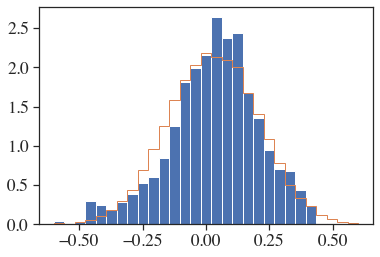

In [34]:
bins = np.linspace(-0.6, 0.6, 30)
plt.hist(d.feh, density=True, bins=bins)
plt.hist(fehs, density=True, histtype='step', bins=bins);

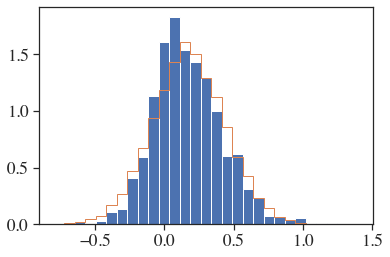

In [35]:
bins = np.linspace(-0.8, 1.4, 30)
plt.hist(d.logplx, density=True, bins=bins)
plt.hist(logplxs, density=True, histtype='step', bins=bins);

In [36]:
mf = MistGridIso()

In [37]:
mf.set_keys(['teff', 'kmag', 'mass', 'radius'])

In [38]:
eeps = np.arange(eep_max)
ones = np.ones_like(eeps)
teffs, kmags, idx, rads, eepints = [], [], [], [], []
n = N#sample
for loga, feh, mass in zip(logages[:n], fehs[:n], masses[:n]):
    _teff, _kmag, _mass, _rad = mf.values(loga*ones, feh*ones, eeps)
    #_idx = np.nanargmin(np.abs(_mass-mass))
    _idxu = np.searchsorted(_mass, mass)
    _idxl = _idxu - 1
    if _idxu == len(eeps):
        idx.append(False)
        continue
    idx.append(True)
    _ml, _mu = _mass[_idxl], _mass[_idxu]
    wl, wu = (_mu-mass)/(_mu-_ml), (mass-_ml)/(_mu-_ml)
    teffs.append(_teff[_idxl]*wl + _teff[_idxu]*wu)
    kmags.append(_kmag[_idxl]*wl + _kmag[_idxu]*wu)
    rads.append(_rad[_idxl]*wl + _rad[_idxu]*wu)
    eepints.append(eeps[_idxl]*wl + eeps[_idxu]*wu)
    #if _teff[_idxl]*wl + _teff[_idxu]*wu != _teff[_idxl]*wl + _teff[_idxu]*wu:
    #    print (_idxl, loga, feh, mass, _mass)
teffs = np.array(teffs)
kmags = np.array(kmags)
rads = np.array(rads)
eepints = np.array(eepints)
idx = np.array(idx)
print (np.sum(idx), 'valid stars.')

7540 valid stars.


In [122]:
eeps = np.arange(eep_max)
ones = np.ones_like(eeps)
teffs, kmags, idx, rads, eepints = [], [], [], [], []
n = N 
for loga, feh, mass in zip(logages[:n], fehs[:n], masses[:n]):
    _teffs, _kmags, _masses, _rads = mf.values(loga*ones, feh*ones, eeps)
    
    _teff = interp1d(_masses, _teffs)(mass)
    _kmag = interp1d(_masses, _kmags)(mass)
    _rad = interp1d(_masses, _rads)(mass)
    _eep = interp1d(_masses, eeps)(mass)
    
    if (0 < _teff < np.inf) and (-np.inf < _kmag < np.inf) & (0 < _rad < np.inf) & (0 < _eep < eep_max):
        idx.append(True)
    else:
        idx.append(False)
        continue

    teffs.append(_teff)
    kmags.append(_kmag)
    rads.append(_rad)
    eepints.append(_eep)

teffs = np.array(teffs)
kmags = np.array(kmags)
rads = np.array(rads)
eepints = np.array(eepints)
idx = np.array(idx)
print (np.sum(idx), 'valid stars.')

7504 valid stars.


In [123]:
dsim = pd.DataFrame(data={
    "teff_true": teffs, "kmag_true": kmags - 5*logplxs[idx] + 10, "eep_true": eepints, "radius_true": rads,
    "mass_true": masses[idx], "age_true": ages[idx], "feh_true": fehs[idx], "parallax_true": 10**logplxs[idx],
    "teff_error": teff_err, "feh_error": feh_err, "kmag_error": kmag_err,
    "parallax_error": 10**logplxs[idx] / parallax_over_err,
})

### add errors

In [124]:
np.random.seed(123)
for key in ["teff", "feh", "kmag", "parallax"]:
    dsim[key+"_obs"] = dsim[key+"_true"] + np.random.randn(len(dsim)) * dsim[key+"_error"]

In [125]:
idxf = np.abs(dsim.feh_obs) < 0.4
print (np.sum(idxf))

7145


In [126]:
dsim = dsim[idxf].reset_index(drop=True)

In [127]:
dsim['kepid'] = ["%05d"%s for s in np.arange(len(dsim))]

(array([ 155.,  354.,  586.,  890., 1108., 1141., 1107.,  828.,  610.,
         366.]),
 array([-3.99868536e-01, -3.19886721e-01, -2.39904906e-01, -1.59923091e-01,
        -7.99412762e-02,  4.05387221e-05,  8.00223536e-02,  1.60004168e-01,
         2.39985983e-01,  3.19967798e-01,  3.99949613e-01]),
 <BarContainer object of 10 artists>)

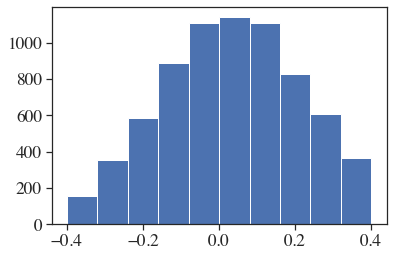

In [129]:
plt.hist(dsim.feh_obs)

In [130]:
dsim.to_csv("simulated-cks3.csv", index=False)

In [46]:
#dold = pd.read_csv("simulated-cks.csv")

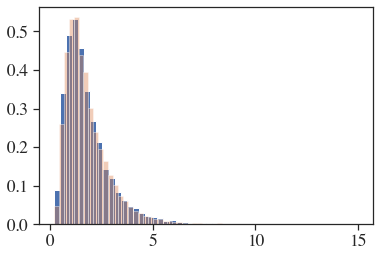

In [53]:
#plt.hist(dsim.parallax_obs, density=True, bins=50)
#plt.hist(dold.parallax_obs, density=True, bins=50, alpha=0.4);